In [1]:
import torch
import pickle
import numpy as np

from torch import nn
from glob import glob
from tqdm import trange
from torch.optim import Adam
from collections import defaultdict
from matplotlib.pyplot import imshow

from torch.nn import functional as F
from matplotlib import pyplot as plt

In [2]:
def getData(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')

    # https://stackoverflow.com/questions/63705615/unable-to-reshape-numpy-array-to-rgb-image
    # i'm dumb asf
    dict[b'data'] = dict[b'data'].reshape(10000, 3, 1024)
    # dict[b'data'] = np.swapaxes(dict[b'data'], 1, 2)
    # dict[b'data'] = dict[b'data'].reshape(10000, 32, 32, 3)
    dict[b'data'] = dict[b'data'].reshape(10000, 3, 32, 32)
    return dict[b'data'], dict[b'labels']

In [3]:
train = defaultdict(list)
test = defaultdict(list)

# load train dataset
for file in glob('/mnt/Seagate/Code/ml-playground/cifar10/data/*[0-9]'):
    data, label = getData(file)
    if len(train['data']) == 0:
        train['data'] = data
        train['label'] = label
    else:
        train['data'] = np.concatenate((train['data'], data))
        train['label'] = np.concatenate((train['label'], label))

# laod test dataset
test['data'], test['label'] = getData(
    "/mnt/Seagate/Code/ml-playground/cifar10/data/test_batch")

# load class names
with open('/mnt/Seagate/Code/ml-playground/cifar10/data/batches.meta', 'rb') as f:
    classes = np.array(pickle.load(f)['label_names'])

['bird' 'truck' 'cat' 'truck' 'ship' 'horse' 'frog' 'automobile' 'frog'
 'airplane' 'dog' 'automobile' 'deer' 'deer' 'automobile' 'dog' 'airplane'
 'frog' 'cat' 'frog' 'truck' 'bird' 'ship' 'ship' 'automobile' 'airplane'
 'truck' 'ship' 'bird' 'frog' 'deer' 'ship' 'airplane' 'frog' 'horse'
 'frog' 'truck' 'ship' 'airplane' 'frog' 'horse' 'horse' 'bird' 'bird'
 'deer' 'bird' 'airplane' 'deer' 'dog' 'cat' 'bird' 'cat' 'cat' 'horse'
 'deer' 'ship' 'horse' 'automobile' 'dog' 'frog' 'cat' 'cat' 'dog'
 'airplane']


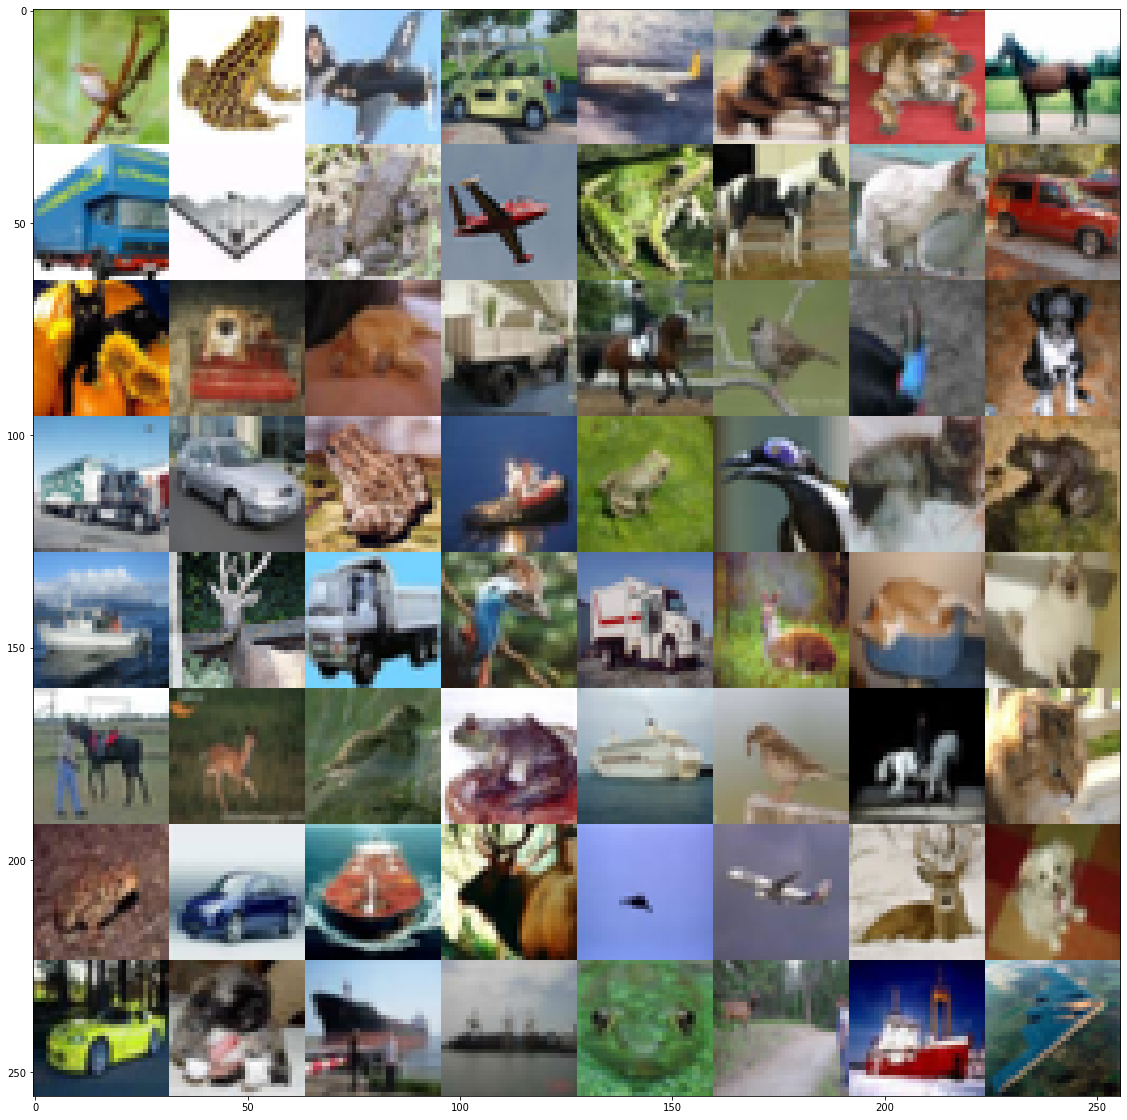

In [4]:
# kinda proud of this xd
size = 64
sqrtSize = 8
plt.figure(figsize=(20, 20))
sampIdx = np.random.randint(low=0, high=50000, size=size)

samp = train['data'][sampIdx]
samp = np.swapaxes(samp, 1, 2)
samp = np.swapaxes(samp, 2, 3)
samp = samp.reshape(sqrtSize, 32*sqrtSize, 32, 3)
samp = np.concatenate(samp, 1)
imshow(samp)
print(classes[np.array(train['label'][sampIdx]).astype(np.int0)])

In [5]:
class JediNet(nn.Module):
    """
    assuming that the shapes of the image and kernel are square
    (INPUT_SIZE - KERNEL_SIZE + (2 * PADDING_SIZE))/STRIDE + 1
    """

    def __init__(self, batch_size=128):
        super(JediNet, self).__init__()
        self.batch_size = batch_size
        self.l1 = nn.Sequential(nn.Conv2d(3, 32, 3, stride=1, padding=1),  # 32, 32, 32
                                nn.ReLU(),
                                nn.Conv2d(32, 64, 3, stride=1, padding=1),  # 32, 32, 64
                                nn.ReLU(),
                                nn.MaxPool2d(2, stride=2))  # 16, 16, 64

        self.l2 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=1, padding=1),  # 16, 16, 128
                                nn.ReLU(),
                                nn.Conv2d(128, 64, 3, stride=1, padding=1),  # 16, 16, 64
                                nn.ReLU(),
                                nn.MaxPool2d(2, stride=2))  # 8, 8, 64

        self.l3 = nn.Sequential(nn.Conv2d(64, 32, 3, stride=1, padding=1),  # 8, 8, 32
                                nn.ReLU(),
                                nn.Conv2d(32, 8, 3, stride=1, padding=1),  # 8, 8, 8
                                nn.ReLU())

        self.fc1 = nn.Linear(8 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

        for layer in self.l1.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.xavier_uniform_(layer.weight)
        for layer in self.l2.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.xavier_uniform_(layer.weight)
        for layer in self.l3.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.xavier_uniform_(layer.weight)
                
        size = self.fc1.weight.size()
        size = np.sqrt(size[0] * size[1])
        nn.init.uniform_(self.fc1.weight, -1./size, 1./size)
        size = self.fc2.weight.size()
        size = np.sqrt(size[0] * size[1])
        nn.init.uniform_(self.fc2.weight, -1./size, 1./size)

        
    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out = out.reshape(batch_size, -1)
        out = F.relu(self.fc1(out))
        out = F.log_softmax(self.fc2(out), dim=1)
        return out

In [6]:
# train model
batch_size = 128
epochs = 5
losses = []
accuracies = []

jediNet = JediNet(batch_size)
optim = Adam(jediNet.parameters(), lr=1e-3)

for i in trange(epochs):
    for _ in range(1000):
        optim.zero_grad()
        samp = np.random.randint(0, 50000, size=batch_size)
        x, y = torch.Tensor(train['data'][samp]), torch.Tensor(
            train['label'][samp]).long()
        y_pred = jediNet(x)
        loss = F.nll_loss(y_pred, y)
        loss.backward()
        optim.step()
        accuracy = (torch.argmax(y_pred, axis=1) == y).float().mean()
        losses.append(loss.item())
        accuracies.append(accuracy)

100%|██████████| 5/5 [33:03<00:00, 396.73s/it]


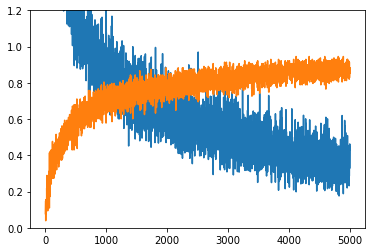

In [7]:
plt.ylim(0, 1.2)
plt.plot(losses)
plt.plot(accuracies)

In [8]:
total = 0
accuracy = 0

with torch.no_grad():
    for i in range(len(test['label'])//batch_size):
        low = i*batch_size
        x = torch.Tensor(test['data'][low: low + batch_size]).float()
        y = torch.Tensor(test['label'][low: low + batch_size]).long()
        y_pred = jediNet(x)
        accuracy += int(torch.sum(y == torch.argmax(y_pred, axis=1)))
        total += batch_size

print(f"Accuracy: {accuracy/total * 100}%")

Accuracy: 72.12540064102564%


In [ ]:

jediNet.state_dict()